In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Read data

In [6]:
ps_battles_dir = 'ps-battles-proc-sub'
ci_fake_dir = 'cifake-sub'

In [4]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
])

data_transforms = {
    'train': train_transforms,
    'val': train_transforms,
    'test': test_transforms
}

In [7]:
ci_fake_dataset = {x: ImageFolder(os.path.join(ci_fake_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
ci_fake_train_val = ConcatDataset([ci_fake_dataset['train'], ci_fake_dataset['val']])

print('Train Ci-fake dataset size:', len(ci_fake_dataset['train']))
print('Val Ci-fake dataset size:', len(ci_fake_dataset['val']))
print('Train + Val Ci-fake dataset size:', len(ci_fake_train_val))
print('Test Ci-fake dataset size:', len(ci_fake_dataset['test']))

Train Ci-fake dataset size: 16000
Val Ci-fake dataset size: 4000
Train + Val Ci-fake dataset size: 20000
Test Ci-fake dataset size: 4000


In [5]:
ps_battles_dataset = {x: ImageFolder(os.path.join(ps_battles_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
ps_battles_train_val = ConcatDataset([ps_battles_dataset['train'], ps_battles_dataset['val']])

print('Train Ps-battles dataset size:', len(ps_battles_dataset['train']))
print('Val Ps-battles dataset size:', len(ps_battles_dataset['val']))
print('Train + Val Ps-battles dataset size:', len(ps_battles_train_val))
print('Test Ps-battles dataset size:', len(ps_battles_dataset['test']))

Train Ps-battles dataset size: 12368
Val Ps-battles dataset size: 3091
Train + Val Ps-battles dataset size: 15459
Test Ps-battles dataset size: 3865


In [8]:
ci_fake_classes = ci_fake_dataset['train'].classes
ci_fake_classes

['fake', 'real']

In [9]:
ps_battles_classes = ps_battles_dataset['train'].classes
ps_battles_classes

['fake', 'real']

In [10]:
full_dataset_train_two_classes = ConcatDataset([ci_fake_dataset['train'], ps_battles_dataset['train']])
full_dataset_val_two_classes = ConcatDataset([ci_fake_dataset['val'], ps_battles_dataset['val']])
full_dataset_test_two_classes = ConcatDataset([ci_fake_dataset['test'], ps_battles_dataset['test']])
full_dataset_train_val_two_classes = ConcatDataset([full_dataset_train_two_classes, full_dataset_val_two_classes])

print('Train full dataset size:', len(full_dataset_train_two_classes))
print('Val full dataset size:', len(full_dataset_val_two_classes))
print('Train + Val full dataset size:', len(full_dataset_train_val_two_classes))
print('Test full dataset size:', len(full_dataset_test_two_classes))

Train full dataset size: 28368
Val full dataset size: 7091
Train + Val full dataset size: 35459
Test full dataset size: 7865


In [11]:
merged_classes = list(set(ci_fake_dataset['train'].classes) | set(ps_battles_dataset['train'].classes))
print("Merged classes:", merged_classes)

Merged classes: ['fake', 'real']


In [12]:
class RenamedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, class_mapping=None):
        self.class_mapping = class_mapping if class_mapping else {}
        super().__init__(root, transform=transform)

        if self.class_mapping:
            new_class_to_idx = {self.class_mapping.get(k, k): v for k, v in self.class_to_idx.items()}
            self.class_to_idx = new_class_to_idx
            self.classes = list(self.class_to_idx.keys())
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

            new_samples = []
            for path, label in self.samples:
                class_name = self.idx_to_class[label]
                new_label = self.class_to_idx[class_name]
                new_samples.append((path, new_label))
            self.samples = new_samples
            self.targets = [label for _, label in self.samples]

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image, label


In [13]:
class_mapping = {'fake': 'edited'}  
ps_battles_renamed_dataset = {x: RenamedImageFolder(os.path.join(ps_battles_dir, x), transform=data_transforms[x], class_mapping=class_mapping) for x in ['train', 'val', 'test']}
ps_battles_renamed_dataset_classes = ps_battles_renamed_dataset['train'].classes
ps_battles_renamed_dataset_classes

['edited', 'real']

In [14]:
class_mapping = {'fake': 'synthetic'}
ci_fake_renamed_dataset = {x: RenamedImageFolder(os.path.join(ci_fake_dir, x), transform=data_transforms[x], class_mapping=class_mapping) for x in ['train', 'val', 'test']}
ci_fake_renamed_dataset_classes = ci_fake_renamed_dataset['train'].classes
ci_fake_renamed_dataset_classes

['synthetic', 'real']

In [15]:
full_dataset_train_three_classes = ConcatDataset([ci_fake_renamed_dataset['train'], ps_battles_renamed_dataset['train']])
full_dataset_val_three_classes = ConcatDataset([ci_fake_renamed_dataset['val'], ps_battles_renamed_dataset['val']])
full_dataset_test_three_classes = ConcatDataset([ci_fake_renamed_dataset['test'], ps_battles_renamed_dataset['test']])
full_dataset_train_val_three_classes = ConcatDataset([full_dataset_train_three_classes, full_dataset_val_three_classes])

print('Train full dataset size:', len(full_dataset_train_three_classes))
print('Val full dataset size:', len(full_dataset_val_three_classes))
print('Train + Val full dataset size:', len(full_dataset_train_val_three_classes))
print('Test full dataset size:', len(full_dataset_test_three_classes))

Train full dataset size: 28368
Val full dataset size: 7091
Train + Val full dataset size: 35459
Test full dataset size: 7865


In [16]:
merged_classes = list(set(ci_fake_renamed_dataset['train'].classes) | set(ps_battles_renamed_dataset['train'].classes))
print("Merged classes:", merged_classes)

Merged classes: ['real', 'edited', 'synthetic']


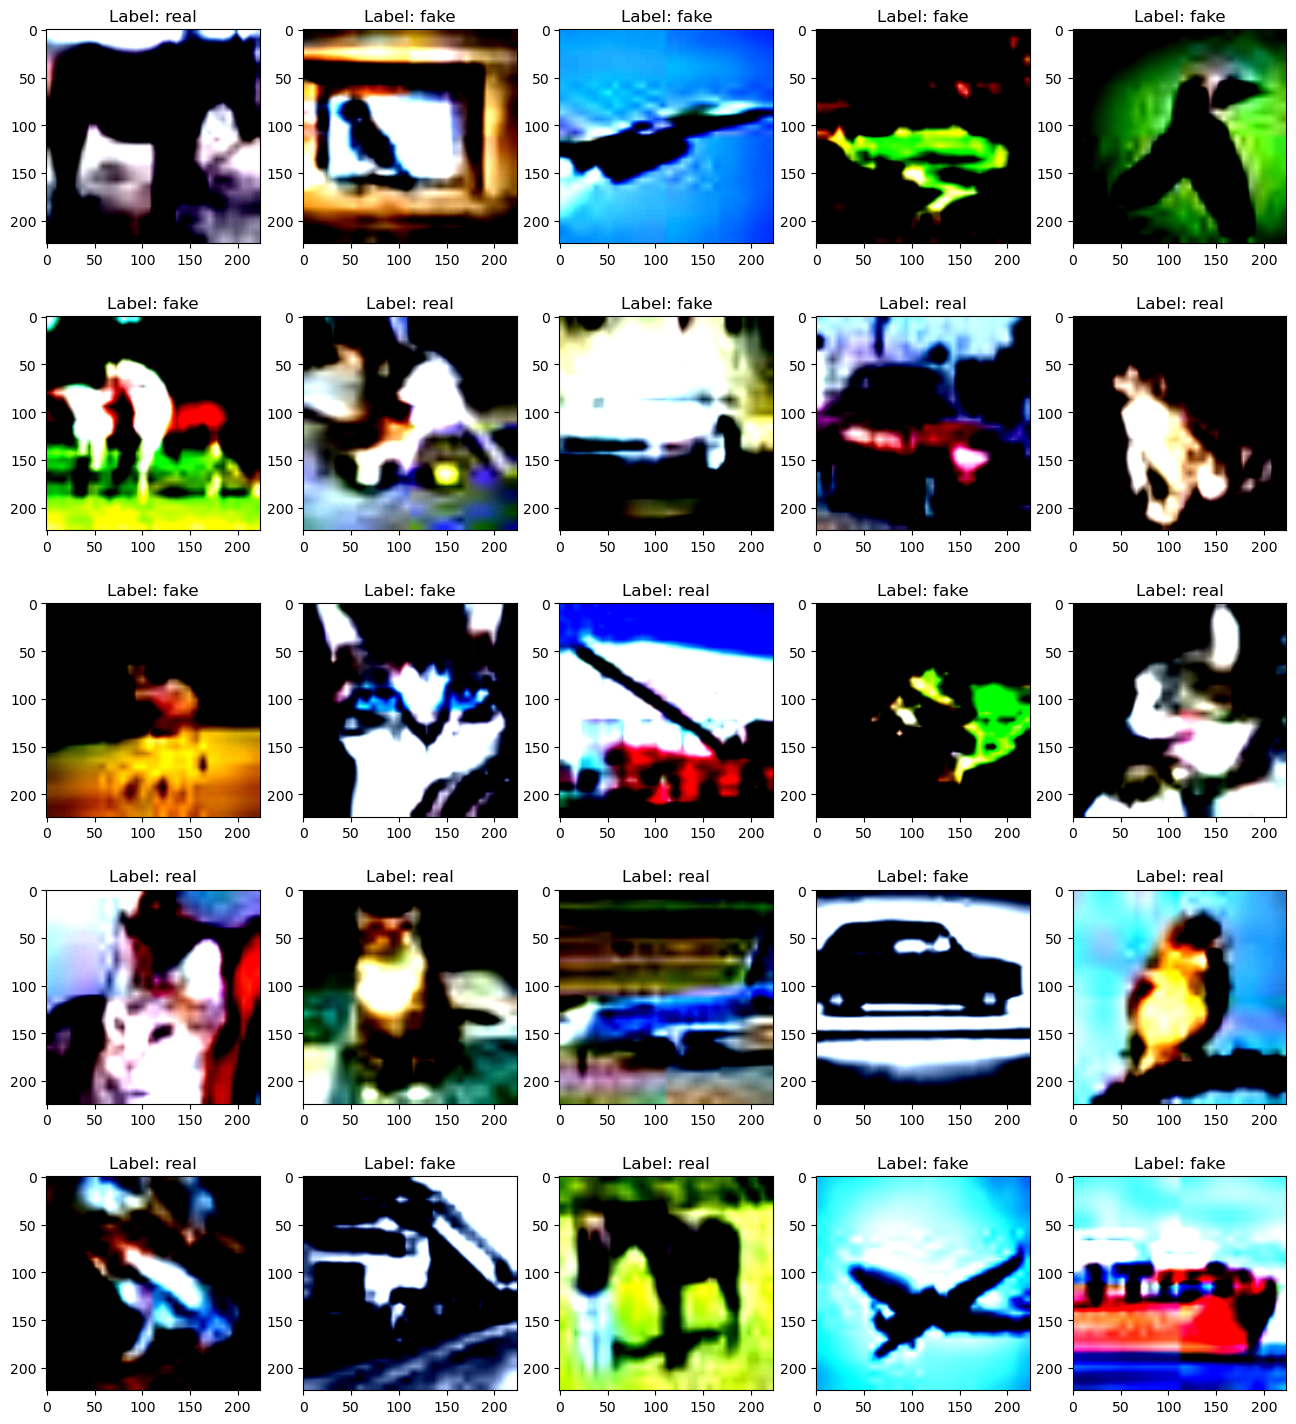

In [39]:
N_IMAGES = 25
indices = random.sample(range(len(ci_fake_dataset['train'])), N_IMAGES)

plt.figure(figsize=(16, 18))
for i, idx in enumerate(indices):
  img = ci_fake_dataset['train'][idx][0].permute(1, 2, 0)
  img = torch.clamp(img, 0, 1)
  label = ci_fake_dataset['train'][idx][1]
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.title(f"Label: {ci_fake_classes[label]}")

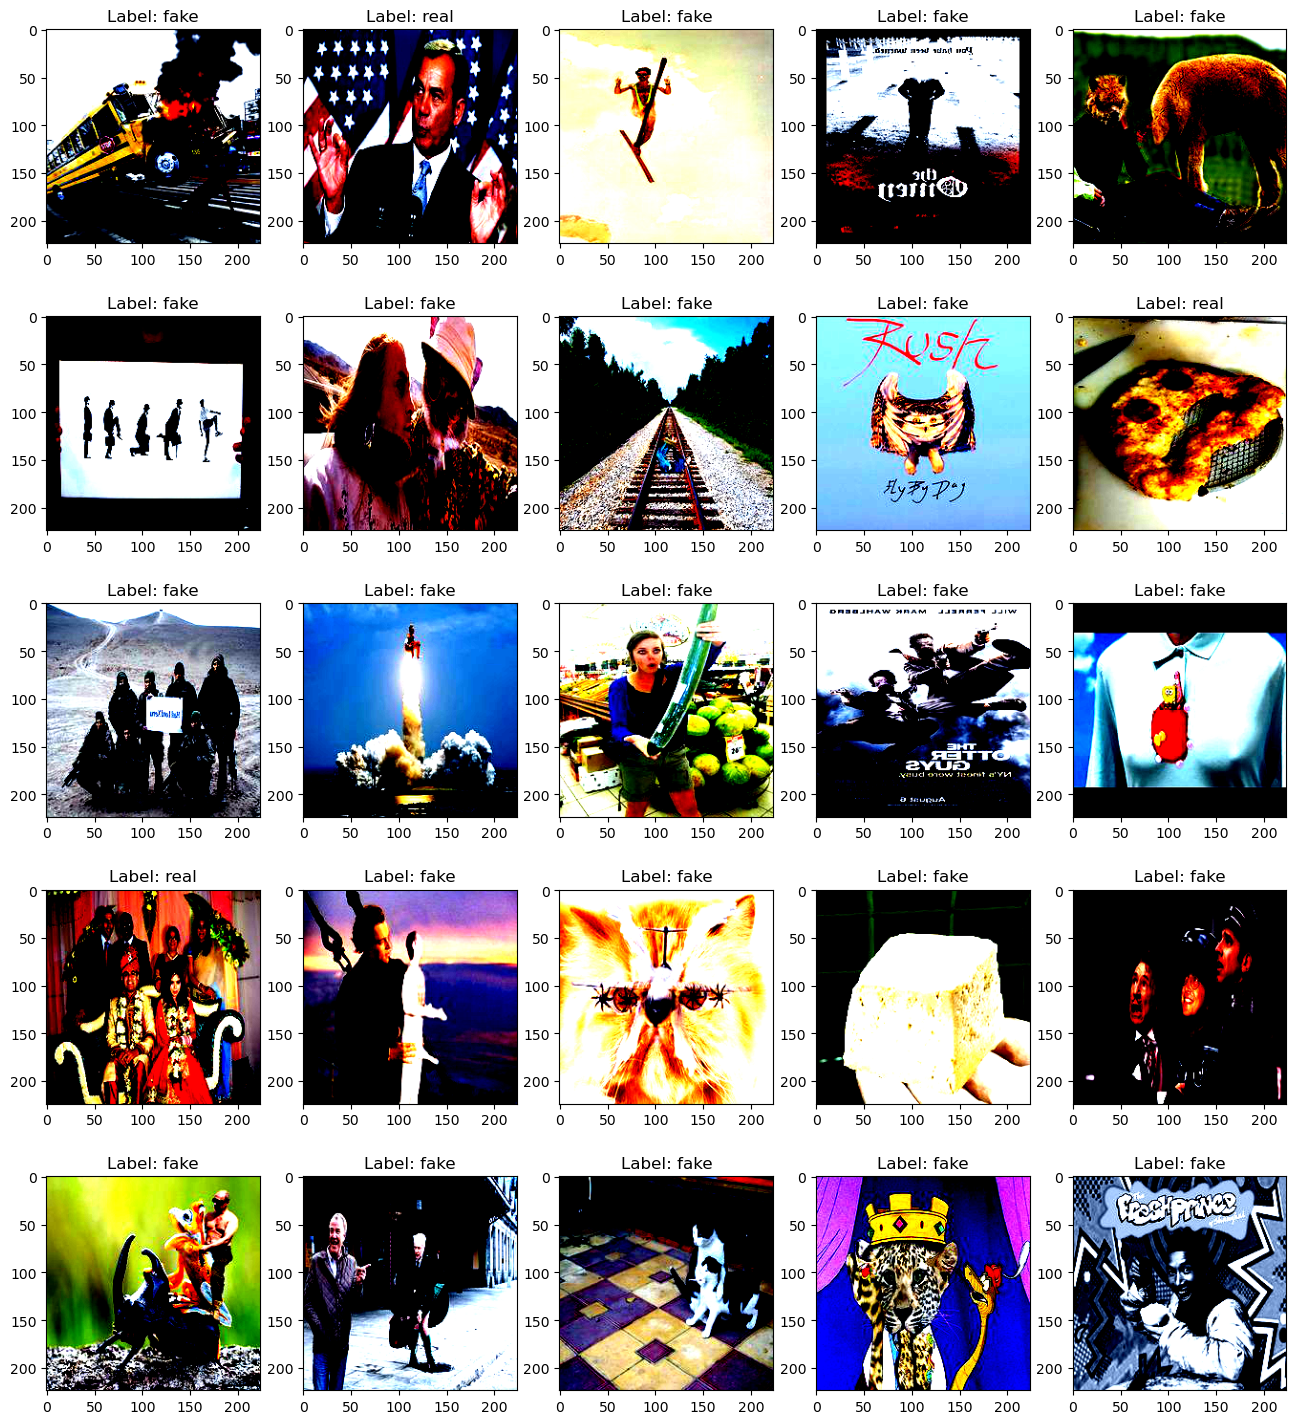

In [40]:
N_IMAGES = 25
indices = random.sample(range(len(ps_battles_dataset['train'])), N_IMAGES)

plt.figure(figsize=(16, 18))
for i, idx in enumerate(indices):
  img = ps_battles_dataset['train'][idx][0].permute(1, 2, 0)
  img = torch.clamp(img, 0, 1)
  label = ps_battles_dataset['train'][idx][1]
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.title(f"Label: {ci_fake_classes[label]}")

### Models

In [16]:
def fit(model, train_dataloader, test_dataloader, epochs, optimizer, loss_function, print_losses=True):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(X_batch)
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_dataloader))

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model.forward(X_batch)
                loss = loss_function(y_pred, y_batch)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_dataloader))

        if print_losses:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        
    return train_losses, test_losses

def predict(model, dataloader):
    all_outputs = []
    for X_batch, _ in dataloader:
        X_batch = X_batch.to(device)
        outputs = model.forward(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_outputs.extend(predicted.numpy())
    return np.array(all_outputs)

In [17]:
def calculate_scores(y_test, y_pred_tab, parameters):
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])

    for param in parameters:
        cm = confusion_matrix(y_test, y_pred_tab)
        print(f'Confusion Matrix for {param}:')
        print(cm, '\n')

        accuracy = round((accuracy_score(y_test, y_pred_tab)*100), 3)
        precision = round((precision_score(y_test, y_pred_tab, average='weighted')*100), 3)
        recall = round((recall_score(y_test, y_pred_tab, average='weighted')*100), 3)
        f1 = round((f1_score(y_test, y_pred_tab, average='weighted')*100), 3)
        results.loc[str(param)] = [accuracy, precision, recall, f1]

    return results

In [18]:
googlenet_model = models.googlenet(weights='IMAGENET1K_V1').to(device)

for param in googlenet_model.parameters():
    param.requires_grad = False

googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 2)

In [19]:
vgg19_model = models.vgg19(weights='IMAGENET1K_V1').to(device)

for param in vgg19_model.parameters():
    param.requires_grad = False

vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 2)

In [20]:
resnet50_model = models.resnet50(weights='IMAGENET1K_V1').to(device)

for param in resnet50_model.parameters():
    param.requires_grad = False

resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 2)

#### Validation

In [24]:
def validate_hyperparams(model, train_dataset, val_dataset, hyperparam_grid, epochs):
    learning_rates = hyperparam_grid.get("learning_rate")
    batch_sizes = hyperparam_grid.get("batch_size")
    optimizers = hyperparam_grid.get("optimizer")

    results = {}

    for lr, batch_size, opt in itertools.product(learning_rates, batch_sizes, optimizers):
        print(f"\nTesting LR={lr}, Batch Size={batch_size}, Optimizer={opt}")

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        loss_function = nn.CrossEntropyLoss()

        if opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr)
        elif opt == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=lr)

        train_losses, val_losses = fit(model, train_dataloader, val_dataloader, epochs, optimizer, loss_function, print_losses=True)

        best_val_loss = min(val_losses)
        results[(lr, batch_size, opt)] = best_val_loss

    print("\n=== Hyperparameter Tuning Results ===")
    for key, loss in results.items():
        print(f"LR={key[0]}, Batch Size={key[1]}, Optimizer={key[2]} -> Best Val Loss: {loss:.4f}")

    best_hyperparams = min(results, key=results.get)
    print(f"\nBest Combination: LR={best_hyperparams[0]}, Batch Size={best_hyperparams[1]}, Optimizer={best_hyperparams[2]} with Loss={results[best_hyperparams]:.4f}")

    return best_hyperparams


In [22]:
hyperparam_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "batch_size": [32, 64, 128, 256],
    "optimizer": ["Adam", "NAdam", "Adagrad"]
}

In [25]:
best_hyperparams_googlenet = validate_hyperparams(
    model=googlenet_model,
    train_dataset=full_dataset_train_two_classes, 
    val_dataset=full_dataset_val_two_classes, 
    hyperparam_grid=hyperparam_grid,
    epochs=10
)
best_lr_googlenet, best_batch_size_googlenet, best_opt_googlenet = best_hyperparams_googlenet


Testing LR=0.0001, Batch Size=32, Optimizer=Adam


KeyboardInterrupt: 

In [ ]:
best_hyperparams_vgg19 = validate_hyperparams(
    model=vgg19_model,
    train_dataset=full_dataset_train_two_classes, 
    val_dataset=full_dataset_val_two_classes, 
    hyperparam_grid=hyperparam_grid,
    epochs=10
)
best_lr_vgg19, best_batch_size_vgg19, best_opt_vgg19 = best_hyperparams_vgg19

In [ ]:
best_hyperparams_resnet50 = validate_hyperparams(
    model=resnet50_model,
    train_dataset=full_dataset_train_two_classes, 
    val_dataset=full_dataset_val_two_classes, 
    hyperparam_grid=hyperparam_grid,
    epochs=10
)
best_lr_resnet50, best_batch_size_resnet50, best_opt_resnet50 = best_hyperparams_resnet50

#### Experiments

##### Ci-fake

In [ ]:
cifake_train_dataloader = DataLoader(ci_fake_train_val, batch_size=best_batch_size_googlenet, shuffle=True)
cifake_test_dataloader = DataLoader(ci_fake_dataset['test'], batch_size=best_batch_size_googlenet, shuffle=False)

fit(googlenet_model, 
    cifake_train_dataloader, 
    cifake_test_dataloader, 
    20, 
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet), 
    nn.CrossEntropyLoss())

predictions_cifake_googlenet = predict(googlenet_model, cifake_test_dataloader)

In [ ]:
cifake_train_dataloader = DataLoader(ci_fake_train_val, batch_size=best_batch_size_vgg19, shuffle=True)
cifake_test_dataloader = DataLoader(ci_fake_dataset['test'], batch_size=best_batch_size_vgg19, shuffle=False)

fit(vgg19_model,
    cifake_train_dataloader, 
    cifake_test_dataloader, 
    20, 
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19), 
    nn.CrossEntropyLoss())

predictions_cifake_vgg19 = predict(vgg19_model, cifake_test_dataloader)

In [ ]:
cifake_train_dataloader = DataLoader(ci_fake_train_val, batch_size=best_batch_size_resnet50, shuffle=True)
cifake_test_dataloader = DataLoader(ci_fake_dataset['test'], batch_size=best_batch_size_resnet50, shuffle=False)

fit(resnet50_model,
    cifake_train_dataloader, 
    cifake_test_dataloader, 
    20, 
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50), 
    nn.CrossEntropyLoss())

predictions_cifake_resnet50 = predict(resnet50_model, cifake_test_dataloader)

In [ ]:
df_cifake = calculate_scores(ci_fake_dataset['test'].targets, 
                             [predictions_cifake_googlenet, predictions_cifake_vgg19, predictions_cifake_resnet50], 
                             ['GoogLeNet', 'VGG19', 'ResNet50'])

##### Ps-battles

In [ ]:
ps_battles_train_dataloader = DataLoader(ps_battles_train_val, batch_size=best_batch_size_googlenet, shuffle=True)
ps_battles_test_dataloader = DataLoader(ps_battles_dataset['test'], batch_size=best_batch_size_googlenet, shuffle=False)

fit(googlenet_model,
    ps_battles_train_dataloader, 
    ps_battles_test_dataloader, 
    20, 
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet), 
    nn.CrossEntropyLoss())

predictions_ps_battles_googlenet = predict(googlenet_model, ps_battles_test_dataloader)

In [ ]:
ps_battles_train_dataloader = DataLoader(ps_battles_train_val, batch_size=best_batch_size_vgg19, shuffle=True)
ps_battles_test_dataloader = DataLoader(ps_battles_dataset['test'], batch_size=best_batch_size_vgg19, shuffle=False)

fit(vgg19_model,
    ps_battles_train_dataloader, 
    ps_battles_test_dataloader, 
    20, 
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19), 
    nn.CrossEntropyLoss())

predictions_ps_battles_vgg19 = predict(vgg19_model, ps_battles_test_dataloader)

In [ ]:
ps_battles_train_dataloader = DataLoader(ps_battles_train_val, batch_size=best_batch_size_resnet50, shuffle=True)
ps_battles_test_dataloader = DataLoader(ps_battles_dataset['test'], batch_size=best_batch_size_resnet50, shuffle=False)

fit(resnet50_model,
    ps_battles_train_dataloader, 
    ps_battles_test_dataloader, 
    20, 
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50), 
    nn.CrossEntropyLoss())

predictions_ps_battles_resnet50 = predict(resnet50_model, ps_battles_test_dataloader)

In [ ]:
df_ps_battles = calculate_scores(ps_battles_dataset['test'].targets,
                                 [predictions_ps_battles_googlenet, predictions_ps_battles_vgg19, predictions_ps_battles_resnet50],
                                 ['GoogLeNet', 'VGG19', 'ResNet50'])

##### Ci-fake + Ps-battles 2 classes

In [ ]:
all_two_classes_train_dataloader = DataLoader(full_dataset_train_val_two_classes, 
                                              batch_size=best_batch_size_googlenet, 
                                              shuffle=True)
all_two_classes_test_dataloader = DataLoader(full_dataset_test_two_classes,
                                                batch_size=best_batch_size_googlenet, 
                                                shuffle=False)

fit(googlenet_model,
    all_two_classes_train_dataloader, 
    all_two_classes_test_dataloader, 
    20, 
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet), 
    nn.CrossEntropyLoss())

predictions_all_two_classes_googlenet = predict(googlenet_model, all_two_classes_test_dataloader)

In [ ]:
all_two_classes_train_dataloader = DataLoader(full_dataset_train_val_two_classes,
                                                batch_size=best_batch_size_vgg19, 
                                                shuffle=True)
all_two_classes_test_dataloader = DataLoader(full_dataset_test_two_classes,
                                                batch_size=best_batch_size_vgg19, 
                                                shuffle=False)

fit(vgg19_model,
    all_two_classes_train_dataloader, 
    all_two_classes_test_dataloader, 
    20, 
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19), 
    nn.CrossEntropyLoss())

predictions_all_two_classes_vgg19 = predict(vgg19_model, all_two_classes_test_dataloader)

In [ ]:
all_two_classes_train_dataloader = DataLoader(full_dataset_train_val_two_classes,
                                                batch_size=best_batch_size_resnet50, 
                                                shuffle=True)
all_two_classes_test_dataloader = DataLoader(full_dataset_test_two_classes,
                                                batch_size=best_batch_size_resnet50, 
                                                shuffle=False)

fit(resnet50_model,
    all_two_classes_train_dataloader, 
    all_two_classes_test_dataloader, 
    20, 
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50), 
    nn.CrossEntropyLoss())

predictions_all_two_classes_resnet50 = predict(resnet50_model, all_two_classes_test_dataloader)

In [ ]:
df_all_two_classes = calculate_scores(full_dataset_test_two_classes.targets,
                                        [predictions_all_two_classes_googlenet, 
                                         predictions_all_two_classes_vgg19, 
                                         predictions_all_two_classes_resnet50],
                                        ['GoogLeNet', 'VGG19', 'ResNet50'])

##### Ci-fake + Ps-battles 3 classes

In [ ]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 3)
vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 3)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 3)

In [ ]:
all_three_classes_train_dataloader = DataLoader(full_dataset_train_val_three_classes,
                                                batch_size=best_batch_size_googlenet, 
                                                shuffle=True)
all_three_classes_test_dataloader = DataLoader(full_dataset_test_three_classes,
                                                batch_size=best_batch_size_googlenet, 
                                                shuffle=False)

fit(googlenet_model,
    all_three_classes_train_dataloader, 
    all_three_classes_test_dataloader, 
    20, 
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet), 
    nn.CrossEntropyLoss())

predictions_all_three_classes_googlenet = predict(googlenet_model, all_three_classes_test_dataloader)

In [ ]:
all_three_classes_train_dataloader = DataLoader(full_dataset_train_val_three_classes,
                                                batch_size=best_batch_size_vgg19, 
                                                shuffle=True)
all_three_classes_test_dataloader = DataLoader(full_dataset_test_three_classes,
                                                batch_size=best_batch_size_vgg19, 
                                                shuffle=False)

fit(vgg19_model,
    all_three_classes_train_dataloader, 
    all_three_classes_test_dataloader, 
    20, 
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19), 
    nn.CrossEntropyLoss())

predictions_all_three_classes_vgg19 = predict(vgg19_model, all_three_classes_test_dataloader)

In [ ]:
all_three_classes_train_dataloader = DataLoader(full_dataset_train_val_three_classes,
                                                batch_size=best_batch_size_resnet50, 
                                                shuffle=True)
all_three_classes_test_dataloader = DataLoader(full_dataset_test_three_classes,
                                                batch_size=best_batch_size_resnet50, 
                                                shuffle=False)

fit(resnet50_model,
    all_three_classes_train_dataloader, 
    all_three_classes_test_dataloader, 
    20, 
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50), 
    nn.CrossEntropyLoss())

predictions_all_three_classes_resnet50 = predict(resnet50_model, all_three_classes_test_dataloader)

In [ ]:
df_all_three_classes = calculate_scores(full_dataset_test_three_classes.targets,
                                        [predictions_all_three_classes_googlenet, 
                                         predictions_all_three_classes_vgg19, 
                                         predictions_all_three_classes_resnet50],
                                        ['GoogLeNet', 'VGG19', 'ResNet50'])